# Install dependencies and import libraries

In [2]:
!pip install -Uqq fastbook fastai duckduckgo_search

I quite like how you can see which libraries are currently installed. Here is a list of all libraries currently available that begin with 'f'.

In [3]:
!pip list | grep "^fast"

fastai                    2.7.13
fastbook                  0.0.29
fastcore                  1.5.29
fastdownload              0.0.7
fastjsonschema            2.16.2
fastprogress              1.0.3


In [4]:
from fastbook import *
from duckduckgo_search import DDGS
from fastcore.all import *
from itertools import islice
from IPython.display import HTML
from shutil import move

# Function definitions

In [5]:
# Search for images and return a list of URLs.
def search_images(term, max_images = 250):
    print(f"Searching for {max_images} '{term}' images...")
    keywords = term
    ddgs_images = ddgs.images(keywords, max_results=max_images)
    #limited_images = list(islice(ddgs_images, max_images))
    return L(ddgs_images).itemgot('image')

In [6]:
# Download images for the specifed search term.
#
# 1. If the search term contains spaces then hyphenate for the folder name.
# 2. Skip if images already exist.
#
def download_image_urls(search_term, max_images, resize=True):
    search = search_images(search_term, max_images)
    dest_search_term = search_term.replace(' ', '-')
    dest = Path(path)/dest_search_term
    if dest.exists() and any(dest.iterdir()):
        num_images_before = len([1 for _ in dest.iterdir()])
        print(f"{num_images_before} images already downloaded in {dest}, skipping download.")
    else:
        dest.mkdir(exist_ok=True, parents=True)
        download_images(dest, urls=search)
        num_images_downloaded = len([1 for _ in dest.iterdir()])
        if resize:
            print(f"Resizing images...")
            resize_images(dest, max_size=400, dest=dest)
        print(f"{num_images_downloaded} images downloaded and resized in {dest}.")

In [7]:
# Verify downloaded files.
#
# 1. Move failed images to '/deleted' folder for inspection.
# 2. Output information on number of files checked, and failed images.
#
def verify_downloaded_images():
    image_files = get_image_files(path)
    num_images_checked = len(image_files)
    print(f"Number of images to be checked: {num_images_checked}")

    failed = verify_images(image_files)

    # Create a 'deleted' folder if it doesn't exist
    deleted_folder = Path(path).parent / 'deleted'
    deleted_folder.mkdir(exist_ok=True)

    for failed_image in failed:
        new_location = deleted_folder / failed_image.name
        print(f"Moving failed image: {failed_image} to {new_location}")
        move(failed_image, new_location)
        
    print(f"Number of failed images moved to 'deleted' folder: {len(failed)}")
    return failed

In [8]:
# Display the images used in the training set, and validation set.
def displayRandomSplitter(v_pct=0.2, sd=42):
    # Get a list of files (or items) in your dataset
    items = get_image_files(path)
    
    # Initialize the RandomSplitter
    splitter = RandomSplitter(valid_pct=v_pct, seed=sd)
    
    # Apply the splitter to your dataset
    train_indices, valid_indices = splitter(items)
    
    # Function to create a DataFrame from file indices
    def create_dataframe(file_indices):
        data = [(items[i].name, items[i].parent.name) for i in file_indices]
        df = pd.DataFrame(data, columns=['Filename', 'Parent Folder'])
        #sorted = df.sort_values(by='Parent Folder')
        return df
    
    # Create DataFrames for training and validation sets
    train_files = create_dataframe(train_indices)
    valid_files = create_dataframe(valid_indices)
    
    # Convert DataFrames to HTML
    train_html = train_files.to_html(index=False)
    valid_html = valid_files.to_html(index=False)
    
    # Display the HTML tables side by side
    html_content = f"""
    <div style="float: left; padding-right: 20px;">
        <h3 style="text-align:center">Training Set Files</h3>
        {train_html}
    </div>
    <div style="float: left;padding-left:50px;">
        <h3 style="text-align:center">Validation Set Files</h3>
        {valid_html}
    </div>
    """
    display(HTML(html_content))

# Download sample images

Download a sample bird image and display it, with the URL underneath.

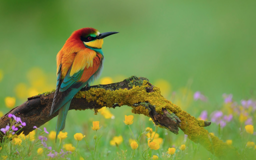

In [9]:
url = search_images_ddg('bird photos', max_images=1)[0]
download_url(url, 'bird.jpg', show_progress=False)
Image.open('bird.jpg').to_thumb(256,256)

In [10]:
url

'http://www.pixelstalk.net/wp-content/uploads/2016/04/Bird-wallpaper-download-free.jpg'

Download a sample forest image, but this time display it using HTML so we can show the image URL when hovered over.

In [11]:
url = search_images_ddg('forest photos', max_images=1)[0]
download_url(url, 'forest.jpg', show_progress=False)
#Image.open('forest.jpg').to_thumb(256,256)

Path('forest.jpg')

In [12]:
html_content = f"""<img src="forest.jpg" width="250px" title="{url}" />"""
display(HTML(html_content))

# Download model images

Download multiple bird and forest images to be used when training the model. First, let's set up the path to store our images in.

In [13]:
path = Path('bird_or_not')
ddgs = DDGS()

Download a specified number of bird images. The `download_image_urls` function

In [14]:
download_image_urls('bird', 250)

Searching for 250 'bird' images...
227 images already downloaded in bird_or_not\bird, skipping download.


In [15]:
download_image_urls('forest', 250)

Searching for 250 'forest' images...
233 images already downloaded in bird_or_not\forest, skipping download.


In [16]:
verify_downloaded_images()

Number of images to be checked: 460
Number of failed images moved to 'deleted' folder: 0


(#0) []

# Create the ML model

In [20]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

The important thing about `dataloaders()` is that it will feed the training algorithm (which runs on the GPU) with multiple images at once, called a batch. The size of the batch is specified via the `bs` parameter.

We can see the list of images that will be used for training and validation by calling `RandomSplitter()` outside of `DataBlock()`.

In [18]:
displayRandomSplitter(0.2, 42)

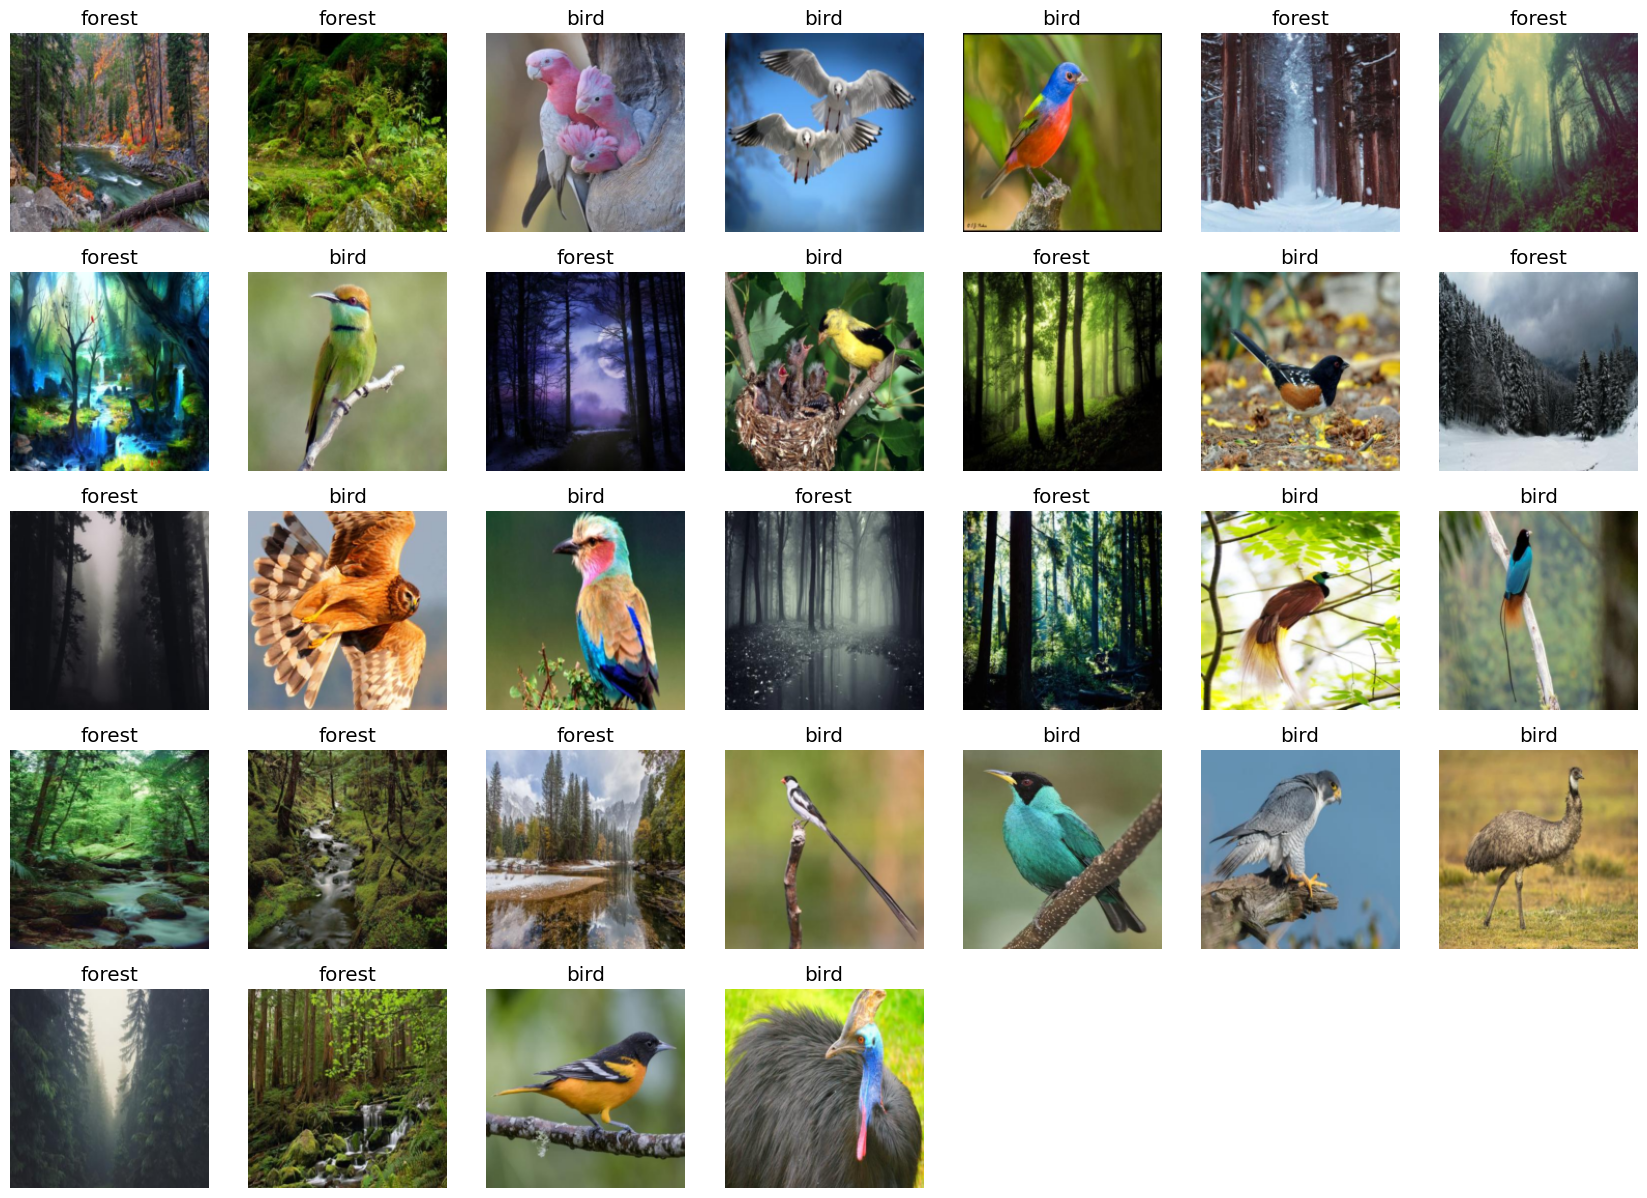

In [19]:
dls.show_batch(max_n=32)

In [27]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

In [28]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


In [29]:
is_bird,_,probs = learn.predict(PILImage.create('forest.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: forest.
Probability it's a bird: 0.0000


# Notes

Notes from Lesson 1 of the course.

## Author code from notebooks

I must have missed this first time around but while looking around on the fastai libray GitHub repository, I realised that the documentaion is written as a notebook, and that the library source code is compiled from the documentation notebooks. That's a pretty efficient way of writing software!

For example, see the source code for the [vision learner](https://github.com/fastai/fastai/blob/master/fastai/learner.py). At the top of the file it has:
> `AUTOGENERATED! DO NOT EDIT! File to edit: ../nbs/13a_learner.ipynb.`

So this means you can effectively write the docs AND the source code at the same time! 🙂

## Delete identical images

Also, when downloading images, after running `verify_images` I'd like to be able to delete duplicate images. Not images that have the same filename, but images that are identical.

I came across multiple instances of the same image when manually reviewing them but it's almost impossible to do this with any accuracy if you're downloading 100's of images. I'm sure theres a package out there that can do this in Python so I'd like to add that to the custom `verify_downloaded_images` function.

That would, of course, only delete images that are 100% identical. I also came across images that had been altered but were basically the same, such as having a different background added, or the image was flipped etc. It might be interesting in this case to run images through a 'screening' ML model that could detect images that are almost identical to one another. This would be very useful when preparing data sets.

Also, it would be nice to be able to check that the sample image you're testing isn't in the training set, and I'd be interested in what happens when you try using a sample image from the training set on purpose to see the model output.

## Layers

One thing I'd like to know is what is actually being created in the neural network when we run `learn.fine_tune(3)`. i.e. What layers have been removed in the `resnet18` original model, and what layers have been added. Is there a way to know exactly how many layers there are in a model?

# Homework
I decided to do a simple classifier to identify happy people! I used 'flowers' for the non-happy people images.

I needed to do quite a bit of manual data cleaning. There were quite a few cartoon type images that I removed, as well as anything that didn't look like it belonged in the data set.

I know that in Lesson 2 Jeremy recommends training the model before doing any data cleaning, but in this notebook there were so many unsuitable images I decided to clean the data before doing any training. 

In [21]:
path = Path('happy_or_not')

In [22]:
download_image_urls('happy person', 250)

Searching for 250 'happy person' images...
172 images already downloaded in happy_or_not\happy-person, skipping download.


In [24]:
download_image_urls('flowers', 250)

Searching for 250 'flowers' images...
245 images already downloaded in happy_or_not\flowers, skipping download.


In [29]:
verify_downloaded_images()

Number of images to be checked: 327
Number of failed images moved to 'deleted' folder: 0


(#0) []

In [30]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

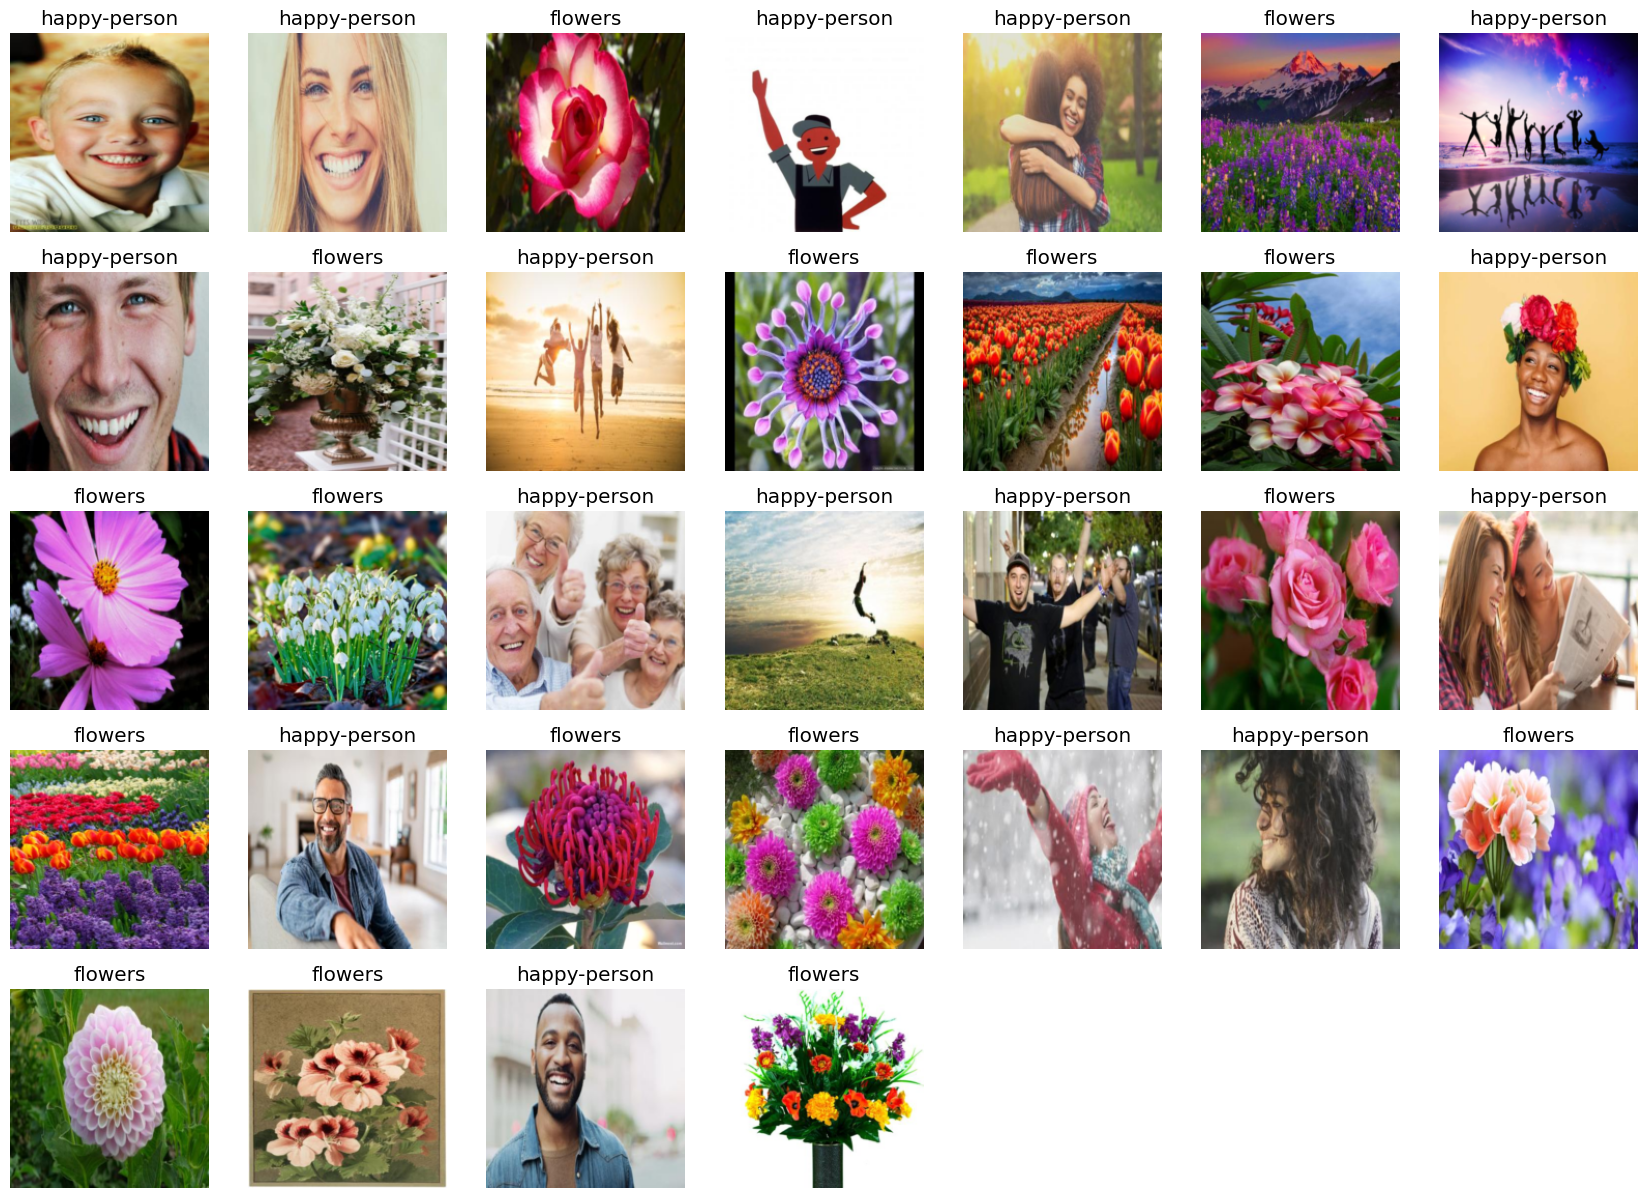

In [31]:
dls.show_batch(max_n=32)

In [32]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

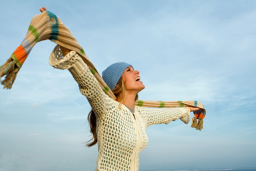

In [33]:
url = search_images_ddg('happy person', max_images=1)[0]
download_url(url, 'happy.jpg', show_progress=False)
Image.open('happy.jpg').to_thumb(256,256)

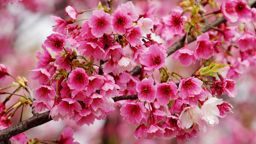

In [34]:
url = search_images_ddg('flowers', max_images=1)[0]
download_url(url, 'flowers.jpg', show_progress=False)
Image.open('flowers.jpg').to_thumb(256,256)

In [41]:
is_happy,_,probs = learn.predict(PILImage.create('happy.jpg'))
print(f"This image is of a happy person: {is_happy}.")
print(f"Probability it's a happy image: {probs[0]:.4f}")

This image is of a happy person: happy-person.
Probability it's a happy image: 0.0000


In [40]:
is_happy,_,probs = learn.predict(PILImage.create('flowers.jpg'))
print(f"This image is of a happy person: {is_happy}.")
print(f"Probability it's a happy image: {probs[0]:.4f}")

This image is of a happy person: flowers.
Probability it's a happy image: 1.0000


# Conclusion
I went through the lesson one video of the course and followed along with the bird classifier, and modified a bit of the code to further my knowledge and experience of Python. Overall I was quite happy with my understanding of most of the topics presented.

I think my biggest takeaway is a desire to understand more about the `fine_tune()` method, and related methods such as `fit_one_cycle()` at a fundamental level. Plus all the `DataBlock` and `DataLoaders` methods/classes.